In [43]:
import numpy as np
import pandas as pd
import torch
import torch.nn
import torch.nn.utils.rnn
import torch.utils.data
import matplotlib.pyplot as plt
from termcolor import colored
import os

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [44]:
data_path = 'data.csv'

In [45]:
#隨機產生資料(最少三個數運算)
def generate_data():
    first_num = np.random.randint(low=0,high=20)
    second_num = np.random.randint(low=0,high=20)
    third_num = np.random.randint(low=0,high=20)
    add = np.random.randint(low=0, high=4) #第一次運算
    add2 = np.random.randint(low=0, high=4) #第二次運算

    match add:
      case 0:
        expression = str(first_num) + '+' + str(second_num)
        result = first_num+second_num
      case 1:
        expression = str(first_num) + '-' + str(second_num)
        result = first_num-second_num
      case 2:
        expression = "("+str(first_num) + '+' + str(second_num)+")"
        result = first_num+second_num
      case 3:
        expression = "("+str(first_num) + '-' + str(second_num)+")"
        result = first_num-second_num
      case 4:
        expression = str(first_num) + '*' + str(second_num)
        result = first_num*second_num


    if add2 == 0: #加法
        expression = expression + '+' + str(third_num)+ "="
        result = result + third_num
    elif add2==1: #減法
        expression = expression + '-' + str(third_num)+ "="
        result = result - third_num
    else : #乘法
        expression = expression+ '*' + str(third_num) + "="
        match add:
          case 0:
            result = first_num+(second_num*third_num)
          case 1:
            result = first_num-(second_num*third_num)
          case 2:
            result = (first_num+second_num)*third_num
          case 3:
            result = (first_num-second_num)*third_num
          case 4:
            result = result * third_num
    return expression, result

generate_data() #測試

('(17+14)-12=', 19)

In [46]:
import numpy as np
import pandas as pd
import csv

In [47]:
#寫入訓練資料
header = ['src', 'tgt']
with open('data.csv', 'w', encoding='UTF8',newline='') as f:
    writer = csv.writer(f)
    num_set=set()
    # write the header
    dic={"":0}
    count=0
    writer.writerow(header)
    while count<20000:
        # write the data
        src,tgt=generate_data()
        if not src+str(tgt) in num_set:
            writer.writerow([src,str(tgt)])
            num_set.add(src+str(tgt))
            count+=1

            if(str(tgt) in dic.keys()):
                dic[str(tgt)]+=1
            else:
                dic[str(tgt)]=1

sort_by_value = dict(sorted(dic.items(), key=lambda item: item[1]))
sort_by_value

{'': 0,
 '-281': 1,
 '358': 1,
 '-314': 1,
 '-317': 1,
 '495': 1,
 '-319': 1,
 '-217': 1,
 '-212': 1,
 '504': 1,
 '-334': 1,
 '379': 1,
 '202': 1,
 '-185': 1,
 '-227': 1,
 '525': 1,
 '-354': 1,
 '334': 1,
 '278': 1,
 '365': 1,
 '246': 1,
 '444': 1,
 '465': 1,
 '335': 1,
 '-330': 1,
 '-339': 1,
 '307': 1,
 '314': 1,
 '-263': 1,
 '429': 1,
 '371': 1,
 '-329': 1,
 '722': 1,
 '-280': 1,
 '274': 1,
 '282': 1,
 '-277': 1,
 '561': 1,
 '-262': 1,
 '269': 1,
 '-248': 1,
 '326': 1,
 '337': 1,
 '263': 1,
 '-183': 1,
 '-286': 1,
 '-294': 1,
 '229': 1,
 '367': 1,
 '481': 1,
 '327': 1,
 '528': 1,
 '-309': 1,
 '-308': 1,
 '-336': 1,
 '-316': 1,
 '-264': 1,
 '-338': 1,
 '-348': 1,
 '-311': 1,
 '578': 1,
 '-271': 1,
 '-352': 1,
 '309': 1,
 '555': 1,
 '344': 1,
 '-333': 1,
 '-298': 1,
 '-318': 1,
 '303': 1,
 '193': 1,
 '-312': 1,
 '462': 1,
 '277': 1,
 '-291': 1,
 '-322': 1,
 '-300': 1,
 '-245': 1,
 '-325': 1,
 '-347': 1,
 '-349': 1,
 '-246': 1,
 '-303': 1,
 '251': 2,
 '-231': 2,
 '341': 2,
 '-305': 2,


In [48]:
df = pd.read_csv(os.path.join(data_path))
# 看一下前幾筆資料是什麼樣子

print(len(df))
df.head()

20000


,src,tgt
0,19+2*15=,49
1,(3-1)-17=,-15
2,17-16-10=,-9
3,(11-18)+5=,-2
4,2+15*0=,2


In [49]:
df['tgt']=df['tgt'].astype(str)
df['tgt']

0         49
1        -15
2         -9
3         -2
4          2
        ... 
19995      3
19996     55
19997     24
19998     47
19999     34
Name: tgt, Length: 20000, dtype: object

In [51]:
# 一個dict把字符轉化成id
char_to_id = {}
# 把id轉回字符
id_to_char = {}

# 有一些必須要用的special token先添加進來(一般用來做padding的token的id是0)
char_to_id['<pad>'] = 0
char_to_id['<eos>'] = 1
id_to_char[0] = '<pad>'
id_to_char[1] = '<eos>'

# 把所有資料集中出現的token都記錄到dict中
for char in set(df['src'].str.cat()):
    ch_id = len(char_to_id)
    char_to_id[char] = ch_id
    id_to_char[ch_id] = char

vocab_size = len(char_to_id)
print('字典大小: {}'.format(vocab_size))
print('char_to_index : ', char_to_id)
print('index_to_char : ', id_to_char)

字典大小: 18
char_to_index :  {'<pad>': 0, '<eos>': 1, '(': 2, '8': 3, '4': 4, '+': 5, '*': 6, '=': 7, '-': 8, ')': 9, '7': 10, '0': 11, '6': 12, '2': 13, '3': 14, '9': 15, '1': 16, '5': 17}
index_to_char :  {0: '<pad>', 1: '<eos>', 2: '(', 3: '8', 4: '4', 5: '+', 6: '*', 7: '=', 8: '-', 9: ')', 10: '7', 11: '0', 12: '6', 13: '2', 14: '3', 15: '9', 16: '1', 17: '5'}


In [52]:
# 把資料集的所有資料都變成id
df['src_char_id_list'] = df['src'].apply(lambda text: [char_to_id[char] for char in list(text)] ) + df['tgt'].apply(lambda text: [char_to_id[char] for char in list(text)]+ [char_to_id['<eos>']] )

df[['src','tgt','src_char_id_list']].head()

,src,tgt,src_char_id_list
0,19+2*15=,49,"[16, 15, 5, 13, 6, 16, 17, 7, 4, 15, 1]"
1,(3-1)-17=,-15,"[2, 14, 8, 16, 9, 8, 16, 10, 7, 8, 16, 17, 1]"
2,17-16-10=,-9,"[16, 10, 8, 16, 12, 8, 16, 11, 7, 8, 15, 1]"
3,(11-18)+5=,-2,"[2, 16, 16, 8, 16, 3, 9, 5, 17, 7, 8, 13, 1]"
4,2+15*0=,2,"[13, 5, 16, 17, 6, 11, 7, 13, 1]"


In [53]:
batch_size = 400
epochs = 50
embed_dim = 256
hidden_dim = 256
lr = 0.001
grad_clip = 1

In [54]:
# 這裏的dataset是文本生成的dataset，輸入和輸出的資料都是文章
# 舉個例子，現在的狀況是：
# input:  A B C D E F
# output: B C D E F <eos>
# 而對於加減法的任務：
# input:x 1 + 2 + 3 = 6
#       y + 2 + 3 = 6 <eos>
#         x:   5 +6 +7=18
#           y: + 6 +7=18<eos>
# output: / / / / / 6 <eos>
# /的部分都不用算loss，主要是預測=的後面，這裏的答案是6，所以output是6 <eos>
class Dataset(torch.utils.data.Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __getitem__(self, index):
        # input:  1 + 2 + 3 = 6
        # output: / / / / / 6 <eos>
        #x= 1+2+3=6
        #y= ppppp6<eos>
        #self.sequences.iloc[index] : 1+ 2+3=6<eos>
        x = self.sequences.iloc[index][:-1]
        y = self.sequences.iloc[index][1:]#self.sequences.iloc[index][self.sequences[index].index(char_to_id['='])+1:]
        # 找到=的索引
        index = y.index(char_to_id['='])
        # 將=左邊的元素設置為0
        y[:index+1] = [0] * (index+1)

        return x, y

    def __len__(self):
        return len(self.sequences)

def collate_fn(batch):

    batch_x = [torch.tensor(data[0]) for data in batch] # list[torch.tensor]
    batch_y = [torch.tensor(data[1]) for data in batch] # list[torch.tensor]
    batch_x_lens = torch.LongTensor([len(x) for x in batch_x])
    batch_y_lens = torch.LongTensor([len(y) for y in batch_y])
    equalidxs=torch.LongTensor([(data == char_to_id['=']).nonzero(as_tuple=True)[0] for data in batch_x])
    # torch.tensor
    # [[1968, 1891, 3580, ... , 0, 0, 0],
    #  [1014, 2242, 2247, ... , 0, 0, 0],
    #  [3032,  522, 1485, ... , 0, 0, 0]]
    #                       padding↑
    pad_batch_x = torch.nn.utils.rnn.pad_sequence(batch_x,
                                                  batch_first=True, # shape=(batch_size, seq_len)
                                                  padding_value=char_to_id['<pad>'])

    pad_batch_y = torch.nn.utils.rnn.pad_sequence(batch_y,
                                                  batch_first=True, # shape=(batch_size, seq_len)
                                                  padding_value=char_to_id['<pad>'])

    return pad_batch_x, pad_batch_y, batch_x_lens, batch_y_lens ,equalidxs

In [55]:
dataset = Dataset(df['src_char_id_list'])
train_data,val_data=torch.utils.data.random_split(dataset,[int(len(dataset) *0.9),int(len(dataset)*0.1)])

In [56]:
dataset.__getitem__(2)


([16, 10, 8, 16, 12, 8, 16, 11, 7, 8, 15], [0, 0, 0, 0, 0, 0, 0, 0, 8, 15, 1])

In [57]:
train_data_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          collate_fn=collate_fn
                                          )
val_data_loader = torch.utils.data.DataLoader(val_data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          collate_fn=collate_fn
                                          )

In [58]:
print(len(train_data_loader))
len(val_data_loader)

45


5

In [60]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
class CharRNN(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(CharRNN, self).__init__()

        # Embedding層
        self.embedding = torch.nn.Embedding(num_embeddings=vocab_size,
                                            embedding_dim=embed_dim,
                                            padding_idx=char_to_id['<pad>'])

        # RNN層
        self.rnn_layer1 = torch.nn.LSTM(input_size=embed_dim,
                                        hidden_size=hidden_dim,
                                        batch_first=True)

        # output層
        self.linear = torch.nn.Sequential(torch.nn.Linear(in_features=hidden_dim,
                                                          out_features=hidden_dim),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(in_features=hidden_dim,
                                                          out_features=vocab_size))


    def forward(self, batch_x, batch_x_lens):
        return self.encoder(batch_x, batch_x_lens)

    def encoder(self, batch_x, batch_x_lens):
        batch_x = self.embedding(batch_x)

        # 假設有個tensor : tensor([[1, 2, 3, 4],
        #                        [9, 0, 0, 0]])
        # 輸出就是：PackedSequence(data=tensor([1, 9, 2, 3, 4]),
        #                         batch_sizes=tensor([2, 1, 1, 1]),
        #                         sorted_indices=None, unsorted_indices=None)
        # torch.nn.utils.rnn.pack_padded_sequence 會把batch當中的句子從長到短排序，建立如上所示的資料結構
        # 就像上一個例子一樣，RNN會先吃第一個batch內的第一個batch_size，看到這個地方的batch_size爲2，所以此時RNN會吃兩個token，輸出一個2Xhidden_dim的向量組
        # 然後看第二個batch_size, 此時爲1，少了一個，說明其中一個序列到頭了，那就取上一個輸出向量的第一個，再生成一個1Xhidden_dim的向量
        # [
        # [1,2,3],                data = [1,4,6,2,5,3]   output  data = [1p,4p,6p,2p,5p,3p]             [1p,2p,3p]
        # [4,5,0], => pack_padded_sequence => batch_sizes = [3,2,1] => RNN => batch_sizes = [3,2,1] => pad_packed_sequence => [4p,5p,0]
        # [6,0,0]         _                                                     [6p,0,0]
        # ]
        batch_x = torch.nn.utils.rnn.pack_padded_sequence(batch_x,
                                                          batch_x_lens,
                                                          batch_first=True,
                                                          enforce_sorted=False)

        batch_x, _ = self.rnn_layer1(batch_x)
        batch_x, _ = torch.nn.utils.rnn.pad_packed_sequence(batch_x,
                                                            batch_first=True)

        batch_x = self.linear(batch_x)

        return batch_x

    def generator(self, start_chars, max_len=200):
        char_list = []
        for char in start_chars:
            char_list.append(char_to_id[char])


        next_char = None
        # Move initial character list to the device
        char_list_tensor = torch.LongTensor(char_list).unsqueeze(0).to(device)
        # 生成的長度沒達到max_len就一直生
        while len(char_list) < max_len:

            x = self.embedding(char_list_tensor)
            _, (ht, _) = self.rnn_layer1(x)
            y = self.linear(ht)

            next_char = np.argmax(y.detach().cpu().numpy())

            # 如果看到新的token是<eos>就說明生成結束了，就停下
            if next_char == char_to_id['<eos>']:
                break

            char_list.append(next_char)
            char_list_tensor = torch.LongTensor(char_list).unsqueeze(0).to(device)

        return [id_to_char[ch_id] for ch_id in char_list]

In [61]:
torch.manual_seed(3)


model = CharRNN(vocab_size,
                embed_dim,
                hidden_dim)
model=model.to(device)
print(model)

CharRNN(
  (embedding): Embedding(18, 256, padding_idx=0)
  (rnn_layer1): LSTM(256, 256, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=18, bias=True)
  )
)


In [62]:
criterion = torch.nn.CrossEntropyLoss(reduction='mean',ignore_index=char_to_id['<pad>'])
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [63]:
from tqdm import tqdm  # 顯示訓練進度條
model = model.to(device)  # 將模型移動到指定的計算設備（GPU 或 CPU）
model.train()  # 設置模型為訓練模式
test_acc = []  # 用於儲存測試準確率的列表
val_losses = []  # 用於儲存驗證集損失的列表
train_losses = []  # 用於儲存訓練集損失的列表
i = 0  # 用於計算訓練過程中的迭代次數
j = 0  # 用於計算驗證過程中的迭代次數
losstemp = 0  # 用於暫存損失值的變數
for epoch in range(1, epochs+1):  # 迭代每個訓練 epoch
    process_bar = tqdm(train_data_loader, desc=f"Training epoch {epoch}")  # 用 tqdm 顯示訓練進度條
    for batch_x, batch_y, batch_x_lens, batch_y_lens, eqidex in process_bar:  # 迭代每個訓練批次
        optimizer.zero_grad()  # 清空梯度
        batch_pred_y = model(batch_x.to(device), batch_x_lens)  # 使用模型進行預測
        batch_pred_y = batch_pred_y[:, :, :]  # 調整預測結果的形狀
        batch_pred_y = batch_pred_y.reshape(batch_size*batch_pred_y.shape[1], vocab_size)  # 調整預測結果的形狀
        batch_y = batch_y.reshape(-1).to(device)  # 調整目標值的形狀
        loss = criterion(batch_pred_y, batch_y)  # 計算損失
        loss.backward()  # 反向傳播
        torch.nn.utils.clip_grad_value_(model.parameters(), grad_clip)  # 梯度裁剪
        optimizer.step()  # 更新模型參數
        i += 1  # 更新迭代次數
        losstemp += loss.item()  # 更新損失暫存值
        if i % 20 == 0:  # 每隔20個批次更新一次進度條顯示
            process_bar.set_postfix(loss=loss.item())  # 更新進度條顯示損失值
    train_losses.append(losstemp)  # 將訓練損失值加入列表
    losstemp = 0  # 重置損失暫存值
    for batch_x, batch_y, batch_x_lens, batch_y_lens, eqidex in val_data_loader:  # 迭代每個驗證批次
        optimizer.zero_grad()  # 清空梯度
        batch_pred_y = model(batch_x.to(device), batch_x_lens)  # 使用模型進行預測
        batch_pred_y = batch_pred_y[:, :, :]  # 調整預測結果的形狀
        batch_pred_y = batch_pred_y.reshape(batch_size*batch_pred_y.shape[1], vocab_size)  # 調整預測結果的形狀
        batch_y = batch_y.reshape(-1).to(device)  # 調整目標值的形狀
        j += 1  # 更新迭代次數
        losstemp += loss.item()  # 更新損失暫存值
        loss = criterion(batch_pred_y, batch_y)  # 計算損失
    val_losses.append(losstemp*4)  # 將驗證損失值加入列表
    validation_process_bar = tqdm(range(50))  # 創建用於測試的進度條
    correctCount = 0  # 用於計算正確的次數
    for i in validation_process_bar:  # 迭代每個測試樣本
        expression, result = generate_data()  # 生成測試數據
        pred = model.generator(expression)  # 使用生成器進行預測
        genStr = ""  # 用於儲存預測的結果字符串
        for x in pred:  # 將預測的結果拼接為字符串
            genStr += x
        if genStr == expression + str(result):  # 判斷預測結果是否正確
            correctCount += 1  # 正確次數加一
    test_acc.append(correctCount/50.0)  # 將測試準確率加入列表
    if epoch % 500 == 0:  # 每500個epoch保存一次模型
        torch.save(model, './models/model_epoch'+str(epoch)+'.pt')  # 保存模型至指定路徑


100%|██████████| 50/50 [00:00<00:00, 403.22it/s]


In [64]:
genStr=model.generator('10+12*13=')
print(genStr)

['1', '0', '+', '1', '2', '*', '1', '3', '=', '1', '5', '8']


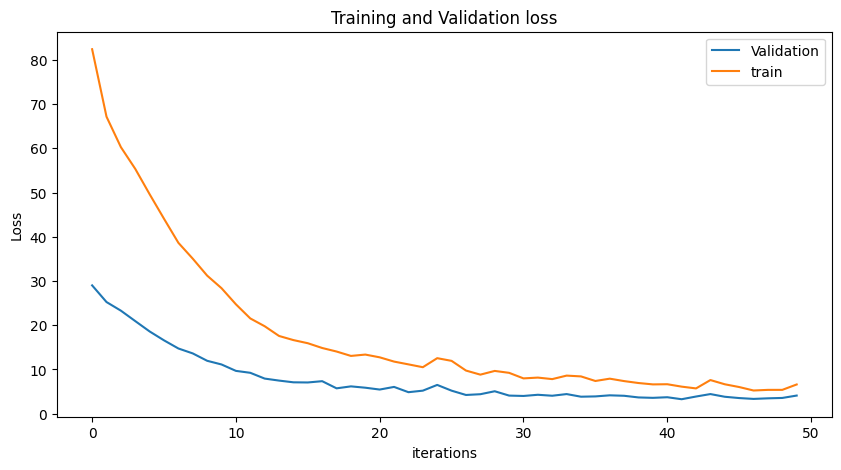

In [65]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation loss")
plt.plot(val_losses,label="Validation")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

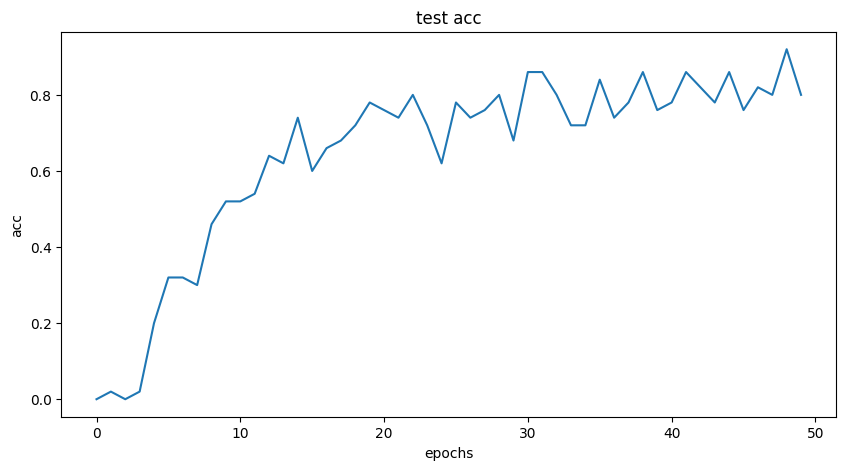

In [66]:
plt.figure(figsize=(10,5))
plt.title("test acc")
plt.plot(test_acc)
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

In [68]:
validation_process_bar = tqdm(range(100))
correctCount=0
for i in validation_process_bar:
    expression,result=generate_data()

    pred = model.generator(expression)

    genStr=""
    for x in pred:
         genStr+= x

    if(genStr==expression+str(result)):
        print(colored("生成正確 ",'green') + colored(genStr,'green'),colored(result,'green'))
        correctCount=correctCount+1
    else:
        print(colored("生成有誤差 ",'red') + colored(genStr,'red'),colored(result,'red'))

print("acc = " + str(correctCount/100.0))

 57%|█████▋    | 57/100 [00:00<00:00, 281.28it/s]

生成正確 (3+9)*11=132 132
生成正確 4-9+17=12 12
生成正確 1-6-15=-20 -20
生成正確 (13-2)*18=198 198
生成正確 (15-6)-3=6 6
生成正確 (1-5)*13=-52 -52
生成正確 7+1+15=23 23
生成有誤差 8+14*7=108 106
生成正確 4-12-14=-22 -22
生成正確 (6-1)*0=0 0
生成正確 16-3*18=-38 -38
生成有誤差 19+13*2=43 45
生成正確 18+18*8=162 162
生成正確 (0-1)+6=5 5
生成有誤差 19-8*3=-7 -5
生成正確 2+15*14=212 212
生成正確 (12+0)*0=0 0
生成正確 (3+14)*10=170 170
生成正確 15+19-2=32 32
生成正確 15-6*0=15 15
生成正確 1-6*11=-65 -65
生成正確 17-10*13=-113 -113
生成有誤差 17+10*10=133 117
生成正確 (10-10)*15=0 0
生成有誤差 1-8*12=-99 -95
生成正確 11-3+9=17 17
生成有誤差 10+3*18=62 64
生成正確 13-7-18=-12 -12
生成正確 (10-10)+11=11 11
生成正確 (7+0)*13=91 91
生成有誤差 13-6*19=-107 -101
生成正確 13-0+16=29 29
生成正確 3-1*0=3 3
生成有誤差 19+16*5=93 99
生成有誤差 10+18*7=134 136
生成有誤差 7+14*17=243 245
生成正確 (11+14)*0=0 0
生成正確 (9-5)+12=16 16
生成正確 (10-13)+4=1 1
生成正確 (19+9)+1=29 29
生成正確 (11+10)-6=15 15
生成有誤差 6-5*7=-31 -29
生成正確 12-3-3=6 6
生成正確 11-11+7=7 7
生成正確 11+2*0=11 11
生成正確 6-5-13=-12 -12
生成正確 1+15-14=2 2
生成有誤差 (2-12)-12=-24 -22
生成有誤差 13+19*8=155 165
生成正確 (13-13)+12=12 

100%|██████████| 100/100 [00:00<00:00, 267.24it/s]

生成正確 0+3*5=15 15
生成正確 (6+15)+8=29 29
生成正確 18-11+2=9 9
生成正確 (0+17)*2=34 34
生成正確 8-7-9=-8 -8
生成有誤差 (2-19)*11=-195 -187
生成正確 (1-8)-17=-24 -24
生成正確 (19+12)*18=558 558
生成正確 12-6*12=-60 -60
生成正確 (9+10)+16=35 35
生成正確 (12-13)-10=-11 -11
生成正確 (3+12)-13=2 2
生成有誤差 9-8*15=-123 -111
生成正確 (8-3)*10=50 50
生成正確 19-8-12=-1 -1
生成有誤差 (17-14)+1=2 4
生成正確 (12-13)*3=-3 -3
生成正確 (10+13)*19=437 437
生成正確 0+0*19=0 0
生成正確 (18+11)*5=145 145
生成正確 9-5+12=16 16
生成有誤差 17-9*19=-144 -154
生成正確 10+16-16=10 10
生成正確 (13+14)*14=378 378
生成正確 (9+4)-8=5 5
生成有誤差 1+10*11=113 111
生成正確 7+12-7=12 12
生成正確 (1+8)*7=63 63
生成正確 1+18*1=19 19
生成正確 (13-7)-16=-10 -10
生成有誤差 18-16*16=-254 -238
生成正確 (0+16)-12=4 4
生成有誤差 2-6*5=-32 -28
生成正確 4+18-18=4 4
生成正確 (5-8)-9=-12 -12
生成正確 3-13+5=-5 -5
生成有誤差 12-11*4=-34 -32
生成有誤差 9-17*1=-10 -8
生成正確 (9-8)*16=16 16
生成正確 7-15+4=-4 -4
生成正確 17+7-0=24 24
生成正確 (17+11)-16=12 12
acc = 0.75
